## Import

In [5]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [80]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':50,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED': 41,
    'DIR' : 'experiment',
    'EXP_NAME' : 'baseline+class_weight+weight_sample+aug'
}

## Fixed RandomSeed

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [9]:
all_img_list = glob.glob('train/*/*')
# all_img_list = [f.replace(os.sep, '/') for f in all_img_list]

In [10]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split(os.sep)[-2])

In [11]:
df['label']

0       가구수정
1       가구수정
2       가구수정
3       가구수정
4       가구수정
        ... 
3452      훼손
3453      훼손
3454      훼손
3455      훼손
3456      훼손
Name: label, Length: 3457, dtype: object

In [12]:
train_data, val_data, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [13]:
le = preprocessing.LabelEncoder()

train_data['label'] = le.fit_transform(train_data['label'])

train_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[train_data['label'].tolist()].tolist()

val_data['label'] = le.transform(val_data['label'])
val_data['label_multi_hot'] = np.eye(len(le.classes_), dtype = np.int32)[val_data['label'].tolist()].tolist()

In [77]:
from collections import Counter

cnt_dict = Counter(train_data['label'].tolist())
total_cnt = len(train_data['label'])
class_loss_weights = [1 - (cnt_dict[c] / total_cnt) * 1.5 for c in range(len(le.classes_))]

In [15]:
le.classes_

array(['가구수정', '걸레받이수정', '곰팡이', '꼬임', '녹오염', '들뜸', '면불량', '몰딩수정', '반점',
       '석고수정', '오염', '오타공', '울음', '이음부불량', '창틀,문틀수정', '터짐', '틈새과다', '피스',
       '훼손'], dtype=object)

## CustomDataset

In [74]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        try :
            image = np.array(Image.open(img_path))
        except :
            print(img_path)
            raise
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [87]:
train_transform = A.Compose([
                            
                            A.ColorJitter(),
                            A.HorizontalFlip(),
                            A.Rotate(limit = 90),
                            A.RandomCropFromBorders(crop_left=0.1, crop_right=0.1, crop_top=0.1, crop_bottom=0.1, always_apply=False, p=1.0),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

## weighted random sampler

In [65]:
cnt_dict = Counter(train_data['label'].tolist())
total_cnt = len(train_data['label'])
class_weights = [1/ cnt_dict[c] for c in range(len(le.classes_))]
class_weights

[0.125,
 0.004651162790697674,
 0.00980392156862745,
 0.006802721088435374,
 0.1,
 0.02631578947368421,
 0.014492753623188406,
 0.01098901098901099,
 0.5,
 0.025,
 0.002403846153846154,
 0.010101010101010102,
 0.06666666666666667,
 0.08333333333333333,
 0.05263157894736842,
 0.008849557522123894,
 0.25,
 0.027777777777777776,
 0.001017293997965412]

In [76]:
train_dataset = CustomDataset(train_data['img_path'].values, np.int64(train_data['label'].values))
sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset) :
    sample_weights[idx] = class_weights[label]
train_sampler = WeightedRandomSampler(sample_weights, num_samples = len(train_dataset), replacement = True)

In [88]:
# train_multi_hot_for_sampler = 

# train_sampler = MultilabelBalancedRandomSampler()

train_dataset = CustomDataset(train_data['img_path'].values, np.int64(train_data['label'].values), train_transform, )
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0, sampler = train_sampler)

val_dataset = CustomDataset(val_data['img_path'].values, np.int64(val_data['label'].values), test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


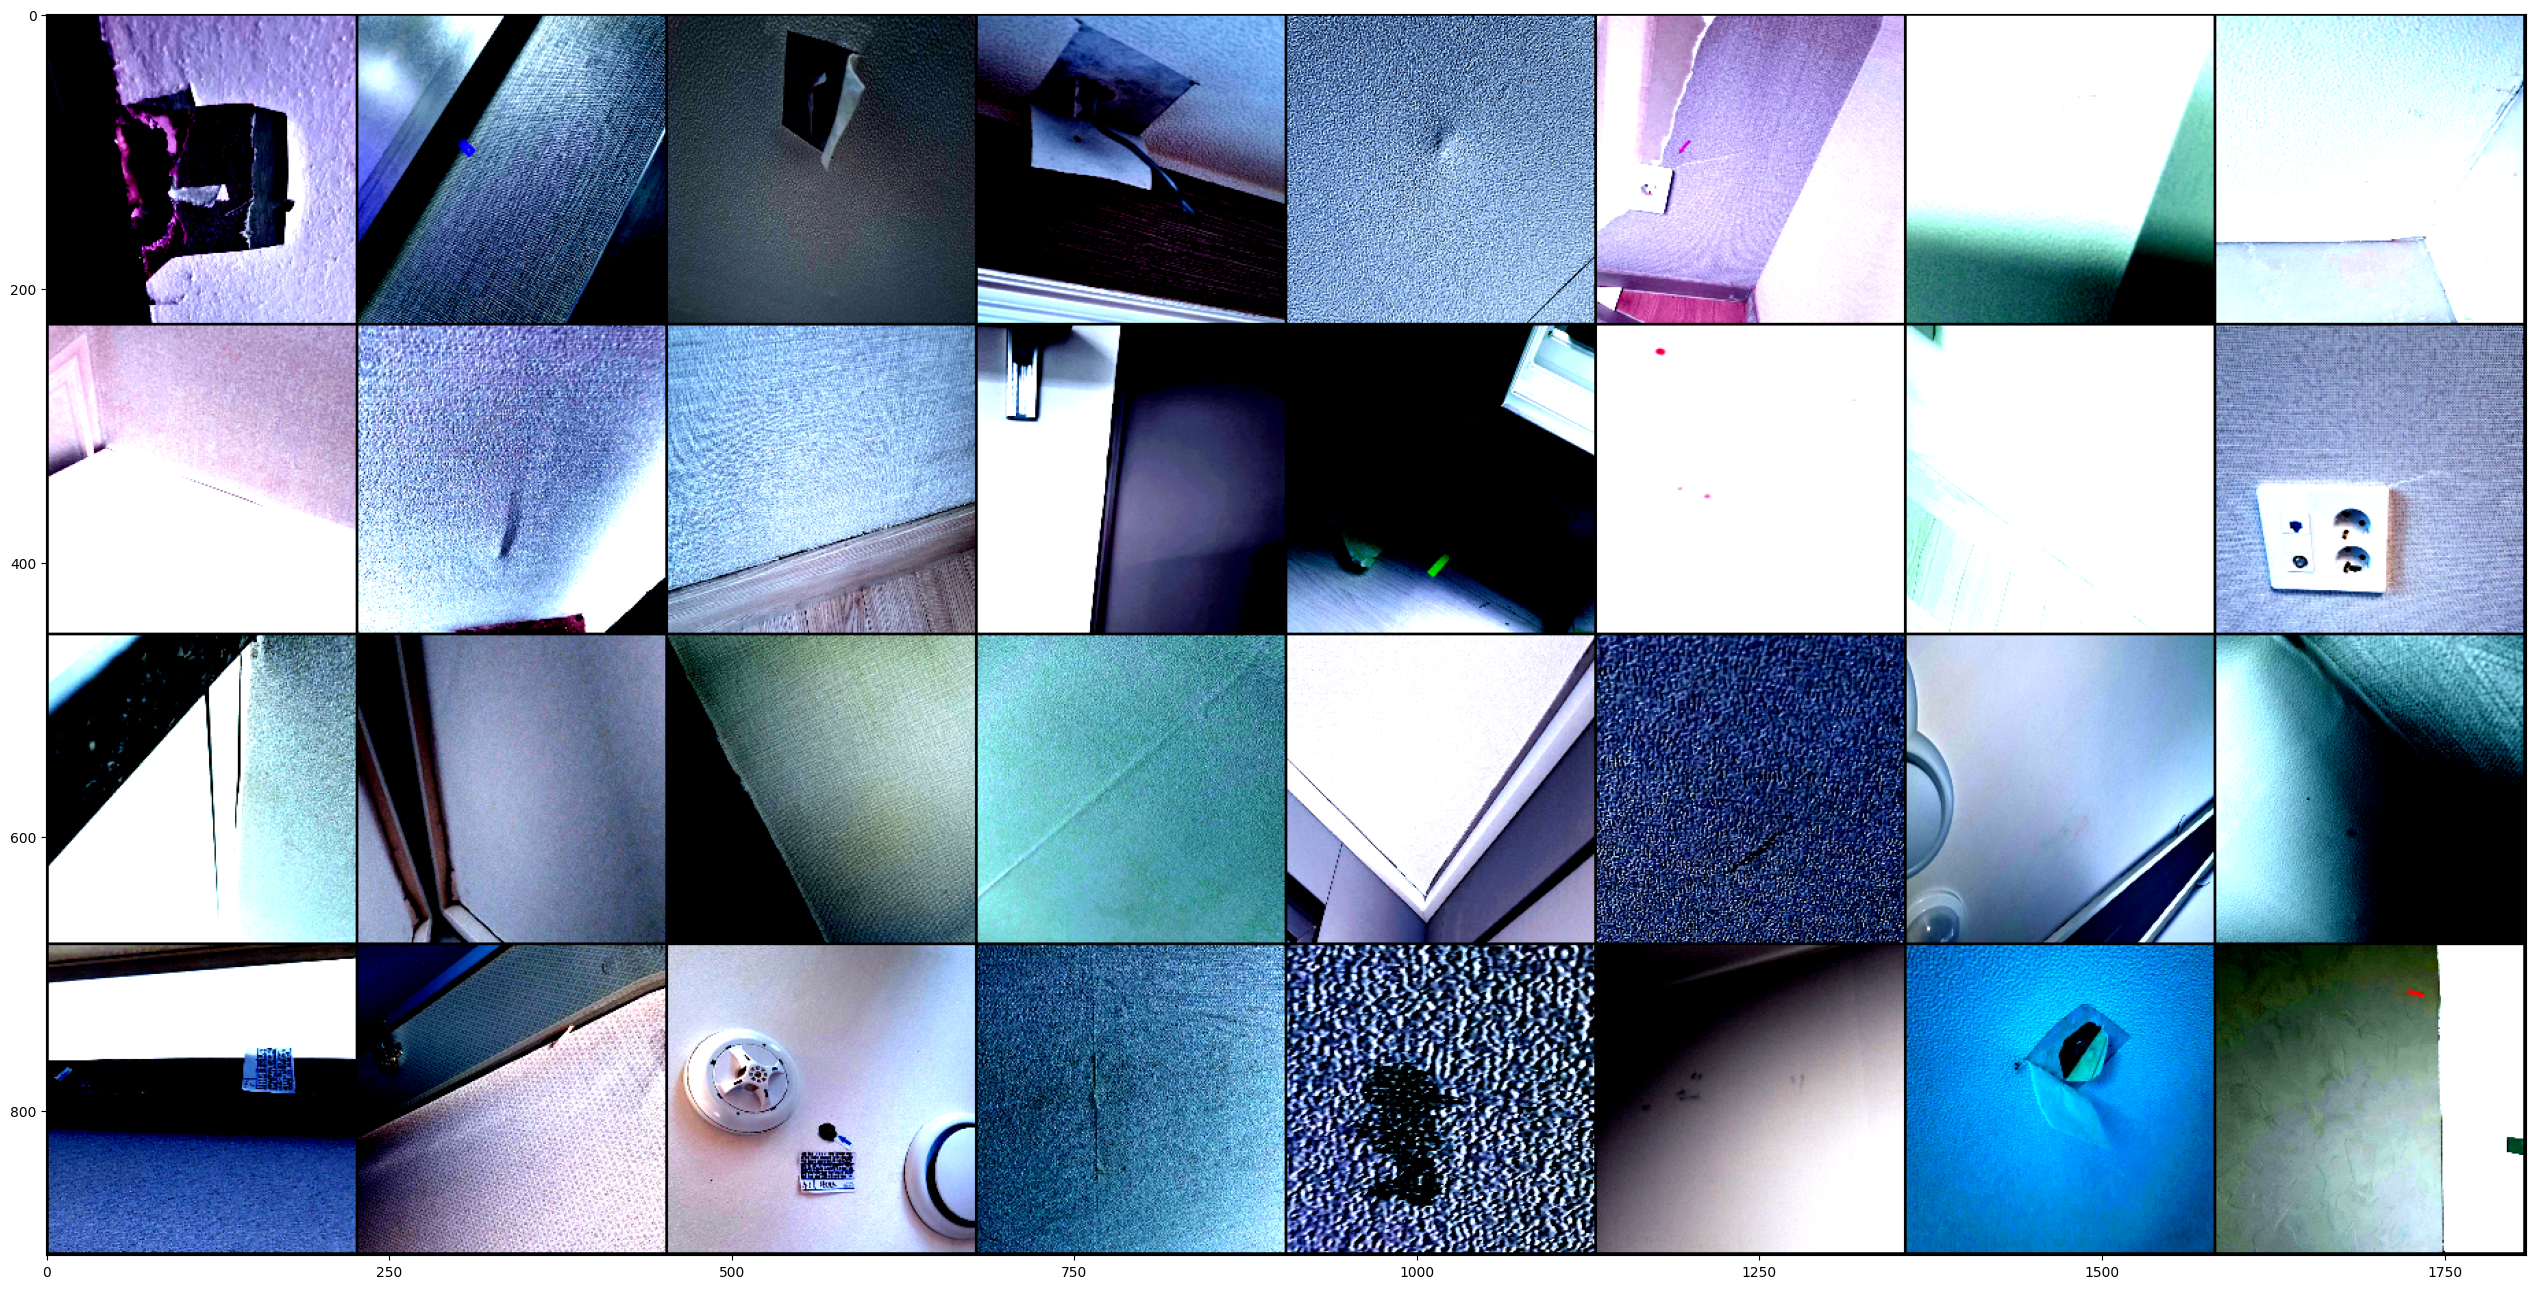

In [110]:
import torchvision

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs).permute(1,2,0).detach().cpu().numpy()

plt.figure(figsize = (32, 64))
plt.imshow(grid)
plt.show()



## Model Define

In [115]:
class LightningModel(pl.LightningModule) :
    def __init__(self, num_classes = len(le.classes_)) :
        super().__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        self.criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_loss_weights))

        self.val_preds = []
        self.val_labels = []
        self.val_loss_list = []

        # self.log_dict(CFG)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx) :
        imgs, labels = batch

        output = self(imgs)
        loss = self.criterion(output, labels)
        self.log('train_loss', loss)

        return loss

    def configure_optimizers(self) :
        optimizer = optim.Adam(self.parameters(), lr=CFG['LEARNING_RATE'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
        monitor = LearningRateMonitor()
        
        return  {"optimizer": optimizer, "lr_scheduler": {'scheduler' : scheduler, 'monitor' : 'val_score'}, 'monitor' : monitor}

    def validation_step(self, batch, batch_idx) :
        imgs, labels = batch
        pred = self(imgs)
        val_loss = self.criterion(pred, labels)
        self.log('val_loss', val_loss)

        self.val_preds += pred.argmax(1).detach().cpu().numpy().tolist()
        self.val_labels += labels.detach().cpu().numpy().tolist()
        self.val_loss_list.append(val_loss.item())


    def on_validation_epoch_end(self) :
        val_loss = np.mean(self.val_loss_list)
        val_f1score = f1_score(self.val_labels, self.val_preds, average = 'weighted')
        
        self.log('mean_val_loss', val_loss)
        self.log('val_score', val_f1score)

        self.val_loss_list.clear()
        self.val_labels.clear()
        self.val_preds.clear()

        return val_loss, val_f1score

    def predict_step(self, batch, batch_idx) :
        x = batch
        pred = self(x)
        return pred



## Train

## Run!!

In [121]:
# callbacks
ckpt_callback = ModelCheckpoint(
    monitor = 'val_loss',
    mode = 'min',
    dirpath = os.path.join(CFG['DIR'], CFG['EXP_NAME']),
    filename = '{epoch}-{val_loss:.2f}-{val_score:.2f}'
)

early_stop_callback = EarlyStopping(
    monitor="train_loss",
    patience=20,
    verbose=False,
    mode="min"
)


tb_logger = pl_loggers.TensorBoardLogger(save_dir = CFG['DIR'], name = CFG['EXP_NAME'])

model = LightningModel()
trainer = pl.Trainer(
    max_epochs = CFG['EPOCHS'],
    accelerator = 'auto',
    precision = 16,
    logger = tb_logger,
    callbacks = [early_stop_callback, ckpt_callback],
)

trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | EfficientNet     | 5.3 M 
1 | classifier | Linear           | 19.0 K
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.230    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 7.5000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 3.7500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00031: reducing learning rate of group 0 to 1.8750e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 9.3750e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 4.6875e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00040: reducing learning rate of group 0 to 2.3437e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00043: reducing learning rate of group 0 to 1.1719e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 5.8594e-07.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 00050: reducing learning rate of group 0 to 2.9297e-07.


## Inference

In [39]:
test = pd.read_csv('./test.csv')

id        img_path
0    TEST_000  ./test/000.png
1    TEST_001  ./test/001.png
2    TEST_002  ./test/002.png
3    TEST_003  ./test/003.png
4    TEST_004  ./test/004.png
..        ...             ...
787  TEST_787  ./test/787.png
788  TEST_788  ./test/788.png
789  TEST_789  ./test/789.png
790  TEST_790  ./test/790.png
791  TEST_791  ./test/791.png

[792 rows x 2 columns]

In [40]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [41]:
model = LightningModel()

infer_model = model.load_from_checkpoint('experiment/baseline+class_weight/epoch=1-val_loss=0.93-val_score=0.73.ckpt')
infer_model

LightningModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [42]:
## inference

trainer = pl.Trainer()
predictions = trainer.predict(infer_model, test_loader)
final_result = []
for pred_batch in predictions :
    final_result += pred_batch.argmax(1).detach().cpu().numpy().tolist()

final_result = le.inverse_transform(final_result)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

## Submission

In [43]:
submit = pd.read_csv('./sample_submission.csv')

In [44]:
submit['label'] = final_result

In [45]:
submit.to_csv('./baseline+class_weight_submit_v3.csv', index=False)